In [1]:
from __future__ import print_function
import tableprint
import numpy as np
import h5py
from deepretina.modeltools import cc, fev, lli
from scipy.stats import pearsonr
from math import isnan
import brewer2mpl as mpl
from os.path import expanduser
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


In [2]:
nepochs = 22
timesteps = [1,5,10,20,40,80,160,320,640,1000]
means = [0.555211298,0.5282853919,0.5351908307,0.5551388928,0.5695032765,0.5639623879,0.5710956735,0.5783625435,0.5843011151,0.5937485128]
stds = [0.003163905844,0.01077038047,0.01814432861,0.01829009758,0.01206938246,0.0198396503,0.01280571367,0.01087448884,0.00858114848,0.006707737675]
stderrs = [s/np.sqrt(nepochs) for s in stds]

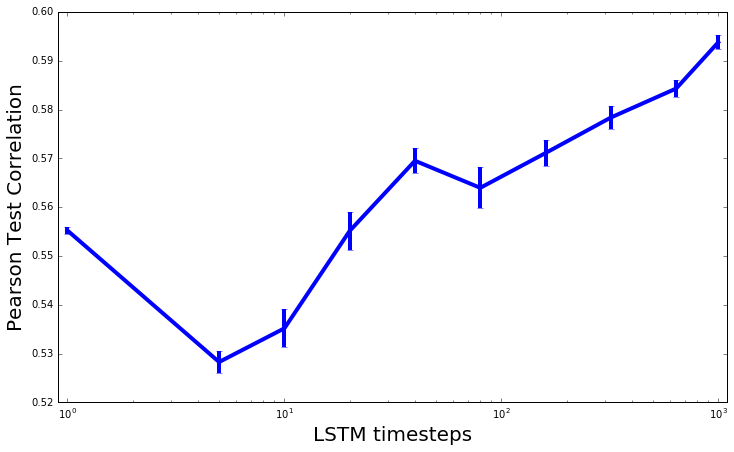

In [3]:
fig = plt.gcf()
fig.set_size_inches((12,7))
plt.errorbar(timesteps, means, yerr=stderrs, linewidth=4)
plt.xscale('log')
plt.xlim([.9, 1100])
plt.xlabel('LSTM timesteps', fontsize=20)
plt.ylabel('Pearson Test Correlation', fontsize=20)

# How does LSTM performance vary as time progresses within a sample?  

We're going to explore the performance of the fixed convnet - LSTM model within a sample as time progresses.

In [4]:
from deepretina.modeltools import *
from deepretina.preprocessing import loadaffine

In [5]:
# model trained on natural scenes
white_model_path = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-12-13 23.20.03 convnet/')
white_weight_name = 'epoch097_iter06950_weights.h5'

# LSTM model
lstm_path = '/Users/lmcintosh/data/deep-retina/saved/lenna.salamander/2016-01-19 02.41.03 fixedlstm/'
lstm_weight_name = 'epoch033_iter00100_weights.h5'

In [22]:
affine_responses = loadaffine([0,1,2,3,4], 'naturalscene', timesteps=1000, method='train', exptdate='15-10-07')

Loading training data... Done.


In [23]:
X = affine_responses.X
y = affine_responses.y

In [24]:
X.shape

(359, 1000, 16)

In [25]:
y.shape

(359, 1000, 5)

In [12]:
natural_lstm = load_model(lstm_path, lstm_weight_name)

INFO (theano.gof.compilelock): Refreshing lock /Users/lmcintosh/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/lmcintosh/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock


In [32]:
predictions = np.zeros_like(y)
for batch in range(0, 359-1, 2):
    predictions[batch:batch+2] = natural_lstm.predict(X[batch:batch+2])

In [34]:
predictions.shape

(359, 1000, 5)

In [49]:
cell_idx = 0
correlations = np.zeros((1000,))
for timestep in range(predictions.shape[1]):
    correlations[timestep] = pearsonr(y[:, timestep, cell_idx],
                                    predictions[:, timestep, cell_idx])[0]

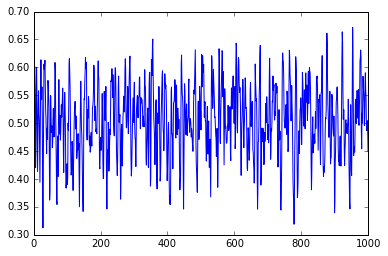

In [50]:
plt.plot(correlations)

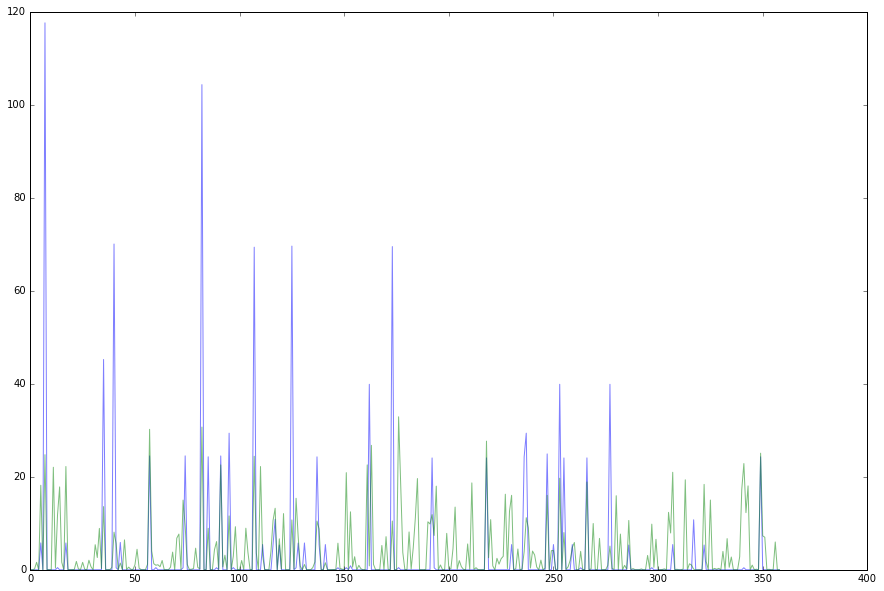

In [44]:
fig = plt.gcf()
fig.set_size_inches((15,10))
plt.plot(y[:, timestep, cell_idx], alpha=0.5)
plt.plot(predictions[:, timestep, cell_idx], 'g', alpha=0.5)

In [45]:
pearsonr(y[0,:,0], predictions[0,:,0])[0]

0.66636489305962088

In [60]:
predictions.shape

(359, 1000, 5)

In [70]:
length = 250
bins = np.linspace(0,1000-length,(1000-length)/length).astype('int')
cell_idx = 0
correlations = np.zeros((len(bins),))
nonnans = 0.0
for sample in range(predictions.shape[0]):
    for idb, timestep in enumerate(bins):
        corr = pearsonr(y[sample, timestep:timestep+length, cell_idx],
                                        predictions[sample, timestep:timestep+length, cell_idx])[0]
        if not isnan(corr):
            correlations[idb] += corr
            nonnans += 1
# correlations /= float(predictions.shape[0])
correlations /= nonnans

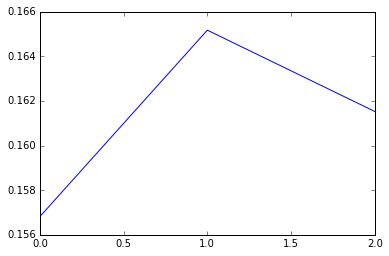

In [72]:
plt.plot(correlations)

In [77]:
cell_idx = 4
correlations = np.zeros((1000,))
for timestep in range(predictions.shape[1]):
    correlations[timestep] = pearsonr(y[:, timestep, cell_idx],
                                    predictions[:, timestep, cell_idx])[0]

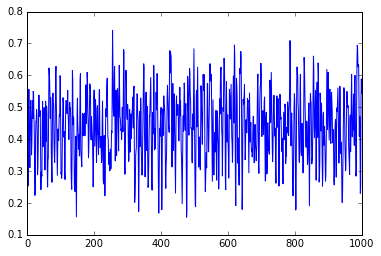

In [78]:
plt.plot(correlations)

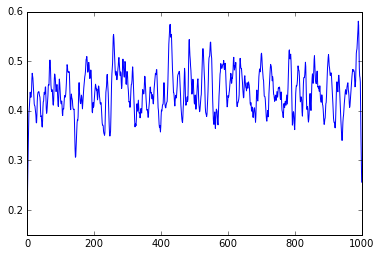

In [82]:
plt.plot(np.convolve(correlations, (1./10.)*np.ones((10,)), 'same'))

In [91]:
ccs = []
for cell_idx in range(4):
    correlations = np.zeros((1000,))
    for timestep in range(predictions.shape[1]):
        correlations[timestep] = pearsonr(y[:, timestep, cell_idx],
                                        predictions[:, timestep, cell_idx])[0]
#     ccs.append(np.convolve(correlations, (1./10.)*np.ones((10,)), 'same'))
    ccs.append(correlations)

In [92]:
all_correlations = np.mean(np.vstack(ccs), axis=0)

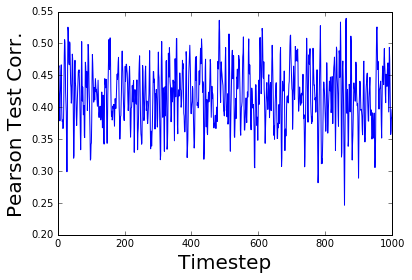

In [96]:
plt.plot(all_correlations)
plt.xlabel('Timestep', fontsize=20)
plt.ylabel('Pearson Test Corr.', fontsize=20)

## courser timestep bins

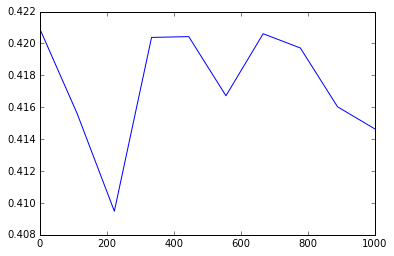

In [94]:
corrs = np.zeros((10,))
for b in range(10):
    corrs[b] = np.mean(all_correlations[b*100:(b+1)*100])
plt.plot(np.linspace(0,1000,10), corrs)

In [110]:
import h5py
import pyret.visualizations as pyviz
import pyret.filtertools as ft
import pyret.spiketools as spktools

In [98]:
f = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/whitenoise.h5', 'r')

In [99]:
list(f)

[u'spikes', u'test', u'train']

In [106]:
spikes = f['spikes/cell01'][:]

In [108]:
bspk, tax = spktools.binspikes(spikes, binsize=0.01)

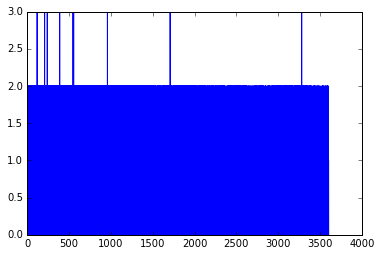

In [109]:
plt.plot(tax, bspk)

In [113]:
h = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/experiment.h5', 'r')

In [116]:
h['cell01'].shape

(43927,)

In [117]:
spikes = h['cell01'][:]

In [121]:
bspk, tax = spktools.binspikes(spikes, binsize=1.00)

In [120]:
np.max(tax)/3600.

2.2219430555555557

In [124]:
fr = spktools.estfr(tax, bspk, sigma=1.00)

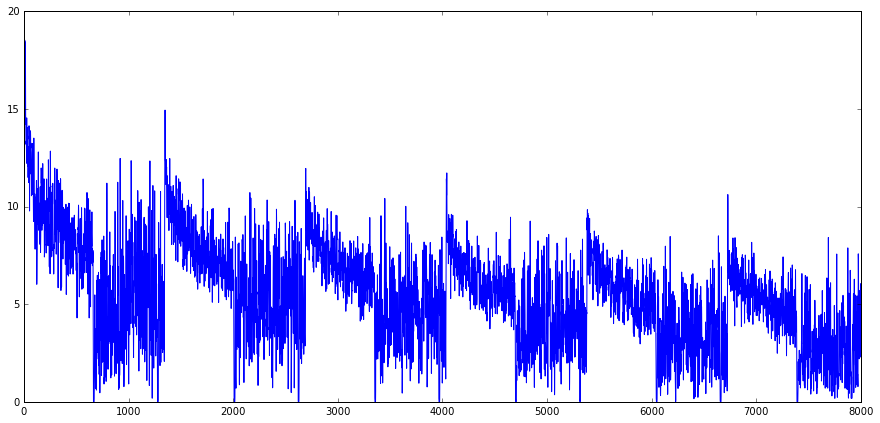

In [126]:
fig = plt.gcf()
fig.set_size_inches((15,7))
plt.plot(tax, fr)

In [127]:
g = h5py.File('/Users/lmcintosh/experiments/data/16-01-08/whitenoise.h5', 'r')

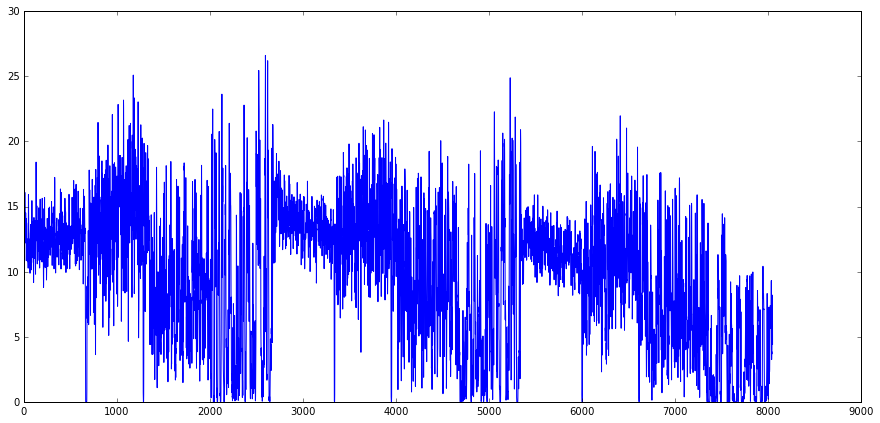

In [136]:
spikes = g['spikes/cell01'][:]
bspk, tax = spktools.binspikes(spikes, binsize=1.00)
fr = spktools.estfr(tax, bspk, sigma=1.00)
fig = plt.gcf()
fig.set_size_inches((15,7))
plt.plot(tax, fr)